In [22]:
import os
import numpy as np
import pandas as pd
import scipy
import ta as ta
import yfinance as yf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LSTM, Dense, Dropout, RepeatVector,Flatten,TimeDistributed,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from ta.utils import dropna
from tsmoothie.smoother import *
from tsmoothie.utils_func import sim_randomwalk

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import date, timedelta
from pickle import dump,load



def CriaDiretorios(raiz_path,ativo,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    
    if os.path.exists(Modelos_CNN)==False:
        os.mkdir(Modelos_CNN)
        
    raiz_path = Modelos_CNN + raiz_path
    
    if os.path.exists(raiz_path)==False:
        os.mkdir(raiz_path)

    Raiz_ativo = raiz_path+"/"+ativo
    
    if os.path.exists(Raiz_ativo)==False:
        os.mkdir(Raiz_ativo)

    return Raiz_ativo+"/"


def preparar_dados_financeiros(ticker,pulo,start="",end="",remove_out=False):

    print(ticker)
    
    if start == "" or end=="":
        base = yf.download(ticker)
        
    elif start !="" and end != "":
        base = yf.download(ticker,start=start,end=end)
        
        
    if base["Open"].tail(1)[0] == 0:
        base = base[:len(base)-1]

    if pulo != 0 and pulo != 1:
        
        base = ReduzirRuido(base,pulo)

    if remove_out:
        return remover_outliers(base)
    else:
        return base
    
    
def preparar_dados_financeiros_porAnos(ticker,pulo,anos_anteriores=4,remove_out=False):

    print(ticker)
    data_atual = date.today()
    data_inicial = (data_atual - timedelta(days=anos_anteriores * 365)).strftime("%Y-%m-%d")
    
    base = yf.download(ticker,start=data_inicial,end=data_atual.strftime("%Y-%m-%d"))
        
    if base["Open"].tail(1)[0] == 0:
        base = base[:len(base)-1]

    if pulo != 0 and pulo != 1:
        
        base = ReduzirRuido(base,pulo)

    if remove_out:
        return remover_outliers(base)
    else:
        return base


def remover_outliers(base):

    z_scores = scipy.stats.zscore(base)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_base = base[filtered_entries]

    return new_base


def ReduzirRuido(base,pulo=5):
    
    de = 0
    ate = pulo
    
    df = base.tail(len(base)-(len(base)%pulo))

    df = df.reset_index()

    lista_diario = list()
    
    for i in range(int(len(df)/pulo)):

        lista_diario.append(df[de:ate])

        de += pulo
        ate += pulo
    
    
    abertura = list()
    fechamento = list()
    maximo = list()
    minimo = list()
    datas = list()

    i = 0
    for triario in lista_diario:

        datas.append(triario["Date"][i])
        abertura.append(triario["Open"][i])
        fechamento.append(triario["Close"][i+(pulo-1)])
        maximo.append(triario["High"].max())
        minimo.append(triario["Low"].min())

        i+=pulo
        
        
    triario = zip(datas,abertura,fechamento,minimo,maximo)
    
    triario_df = pd.DataFrame(triario,columns=["Date","Open","Close","Low","High"])
    
    triario_df = triario_df.set_index("Date")

    return triario_df


def GetTsi(base, gaussian_knots, gaussian_sigma):

    tsi_config = [25, 13]

    resultados_tsi = ta.momentum.TSIIndicator(
        base["Close"], tsi_config[0], tsi_config[1], False)

    tsi_df = pd.DataFrame(resultados_tsi.tsi())

    tsi_df.dropna(inplace=True)
    
    tsi_np = tsi_df["tsi"].to_numpy()
    tsi_np.reshape(1, len(tsi_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(tsi_np)

    tsi_df["gaussian"] = smoother.smooth_data[0]
    
    return tsi_df


def preparar_dados_para_treinamento(anteriores, base_treinamento_normalizada):

    previsores = []
    preco_real = []

    for i in range(anteriores, len(base_treinamento_normalizada)):

        previsores.append(base_treinamento_normalizada[i-anteriores:i, 0])
        preco_real.append(base_treinamento_normalizada[i, 0])

    previsores, preco_real = np.array(previsores), np.array(preco_real)
    previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

    return previsores, preco_real


def Normalizar(base, coluna):

    normalizador = MinMaxScaler(feature_range=(0, 1))

    if coluna == "tsi":
        Oscilador_treinamento = Oscbaseilador.iloc[:, 0:1].values

    if coluna == "gaussian":
        Oscilador_treinamento = base.iloc[:, 1:2].values


    Oscilador_normalizado = normalizador.fit_transform(Oscilador_treinamento)

    return Oscilador_normalizado, normalizador


def Realizar_previsoes(quantidade_de_previsoes,base,modelo,normalizador,coluna):
    
    #Verifica automaticamente quantos dias anteriores o modelo utiliza
    config = modelo.get_config()
    configuracao = config["layers"][0]["config"]["batch_input_shape"]
    
    anteriores=configuracao[1]
    #--------------------------------------------------------------
    
    #Pega os ultimos n registros da base
    
    if coluna == "ewm":
        entradas = base["ewm"].tail(anteriores).values
        
    if coluna == "gaussian":
        
        entradas = base["gaussian"].tail(anteriores).values
        
    entradas_ = entradas.reshape(-1,1)
    entradas_ = normalizador.transform(entradas_)

    i=0
    while i < quantidade_de_previsoes:

        X_teste = []

        X_teste.append(entradas_[-anteriores:])

        X_teste = np.array(X_teste)
        X_teste = np.reshape(X_teste,(X_teste.shape[0],X_teste.shape[1],1))

        previsao = modelo.predict(X_teste)
        previsao = normalizador.inverse_transform(previsao)    

        entradas = np.append(entradas,previsao)

        entradas_ = entradas.reshape(-1,1)

        entradas_ = normalizador.transform(entradas_)

        i+=1

    return entradas[-quantidade_de_previsoes:]


def Carregar_modelo(modelo):
    
    modelo = keras.models.load_model(modelo,compile=False)
    modelo.compile()
    return modelo

def Carregar_escalonador(scaler):
    scaler = load(open(scaler, 'rb'))
    return scaler


def Get_modelos(ticker,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    Modelos = Modelos_CNN + "Modelos"
    Ticker_Modelos = Modelos+"/"+ticker
    modelos = []
    
    if os.path.exists(Ticker_Modelos):

        for model in os.listdir(Ticker_Modelos):

            if model.endswith(".h5"):
                
                if tipo_treinamento in model:
                    
                    modelos.append(Carregar_modelo(Ticker_Modelos+"/"+model))
                    
        return modelos

    else:
        print("Nao existem modelos para esse ativo")
        return []

    
def Get_Scaler(ticker,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    Scallers  = Modelos_CNN + "Scaller"
    Ticker_Scaller = Scallers+"/"+ticker
    
    if os.path.exists(Ticker_Scaller):

        for scaler in os.listdir(Ticker_Scaller):

            if scaler.endswith(".pkl"):

                if tipo_treinamento in scaler:
                    
                    return [Carregar_escalonador(Ticker_Scaller+"/"+scaler)]

        return []
    else:
        print("Nao existe escalonadores para esse ativo")
        return []


def Realizar_previsoes(quantidade_de_previsoes,base,modelo,normalizador,coluna):
    
    
    #Verifica automaticamente quantos dias anteriores o modelo utiliza
    config = modelo.get_config()
    configuracao = config["layers"][0]["config"]["batch_input_shape"]
    
    anteriores=configuracao[1]
    #--------------------------------------------------------------
    
    #Pega os ultimos n registros da base
            
    if coluna == "gaussian":
        
        entradas = base["gaussian"].tail(anteriores).values
        
    entradas_ = entradas.reshape(-1,1)
    entradas_ = normalizador.transform(entradas_)

    i=0
    while i < quantidade_de_previsoes:

        X_teste = []

        X_teste.append(entradas_[-anteriores:])

        X_teste = np.array(X_teste)
        X_teste = np.reshape(X_teste,(X_teste.shape[0],X_teste.shape[1],1))

        previsao = modelo.predict(X_teste)
        previsao = normalizador.inverse_transform(previsao)    

        entradas = np.append(entradas,previsao)

        entradas_ = entradas.reshape(-1,1)

        entradas_ = normalizador.transform(entradas_)

        i+=1

    return entradas[-quantidade_de_previsoes:]


#ESTRUTURAS DOS MODELOS CNN
def Convolutional_01(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN01.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_02(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN02.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_03(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN03.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_04(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN04.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_05(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN05.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_06(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN06.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_07(ticker,filepath_model,base_normalizada):
    
    anteriores= 90
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN07.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model
    
    
def Convolutional_08(ticker,filepath_model,base_normalizada):
    
    anteriores= 90
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)
    
    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN08.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model
    
    
def Convolutional_09(ticker,filepath_model,base_normalizada):
    
    anteriores= 90

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN09.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_10(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN10.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_11(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN11.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_12(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN12.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Criar_redes_convolucionais(ticker,filepath_scaller,filepath_model,pulo,data_inicial,data_final,g_knots=80,g_sigma=0.0009):
       
    if pulo <= 4:
        
        tipo_treinamento = Retorna_tipoTreinamento(pulo)
        
        filepath_scaller= filepath_scaller + tipo_treinamento
        filepath_model = filepath_model + tipo_treinamento
        
        ticker_sem_sa = ticker.split(".")[0]
        
        ativo_df = preparar_dados_financeiros(ticker,pulo,start=data_inicial,end=data_final,remove_out=False)
         
        tsi_df= GetTsi(ativo_df,g_knots,g_sigma)

        base_normalizada,scaler = Normalizar(tsi_df, "gaussian")
        
        #SALVA ESCALONADOR
        dump(scaler, open(filepath_scaller+"_"+ticker_sem_sa+'_scaller.pkl', 'wb'))

        Convolutional_01(ticker,filepath_model,base_normalizada)
        Convolutional_02(ticker,filepath_model,base_normalizada)
        Convolutional_03(ticker,filepath_model,base_normalizada)
        Convolutional_04(ticker,filepath_model,base_normalizada)
        Convolutional_05(ticker,filepath_model,base_normalizada)
        Convolutional_06(ticker,filepath_model,base_normalizada)
        Convolutional_07(ticker,filepath_model,base_normalizada)
        Convolutional_08(ticker,filepath_model,base_normalizada)
        Convolutional_09(ticker,filepath_model,base_normalizada)
        Convolutional_10(ticker,filepath_model,base_normalizada)
        Convolutional_11(ticker,filepath_model,base_normalizada)
        Convolutional_12(ticker,filepath_model,base_normalizada)
        
    else:
        print("O limite do agrupamento de dados e 4")
        

def Retorna_tipoTreinamento(pulo):
    
    tipo_treinamento = ""

    if pulo == 2:
        tipo_treinamento = "2_em_2"

    elif pulo == 3:
        tipo_treinamento = "3_em_3"

    elif pulo == 4:
        tipo_treinamento = "4_em_4"

    else:
        tipo_treinamento = "diario"
        
    return tipo_treinamento

In [23]:
#CRIA OS 12 MODELOS CNN

ativo = "KLBN11.SA"
pulo = 1
data_inicial = "2010-01-01"
data_fianl = "2023-07-09"
tipo_treinamento = Retorna_tipoTreinamento(pulo)

Scaler_path = CriaDiretorios("Scaller",ativo,tipo_treinamento)
Modelos_path = CriaDiretorios("Modelos",ativo,tipo_treinamento)


Criar_redes_convolucionais(ativo,Scaler_path,Modelos_path,pulo,data_inicial,data_final)

KLBN11.SA
[*********************100%***********************]  1 of 1 completed
Epoch 1/200
64/64 - 17s - loss: 0.0529 - 17s/epoch - 264ms/step
Epoch 2/200
64/64 - 2s - loss: 0.0112 - 2s/epoch - 31ms/step
Epoch 3/200
64/64 - 2s - loss: 0.0082 - 2s/epoch - 31ms/step
Epoch 4/200
64/64 - 2s - loss: 0.0058 - 2s/epoch - 31ms/step
Epoch 5/200
64/64 - 2s - loss: 0.0056 - 2s/epoch - 31ms/step
Epoch 6/200
64/64 - 2s - loss: 0.0047 - 2s/epoch - 32ms/step
Epoch 7/200
64/64 - 2s - loss: 0.0047 - 2s/epoch - 29ms/step
Epoch 8/200
64/64 - 2s - loss: 0.0044 - 2s/epoch - 31ms/step
Epoch 9/200
64/64 - 2s - loss: 0.0037 - 2s/epoch - 31ms/step
Epoch 10/200
64/64 - 2s - loss: 0.0038 - 2s/epoch - 29ms/step
Epoch 11/200
64/64 - 2s - loss: 0.0047 - 2s/epoch - 29ms/step
Epoch 12/200
64/64 - 2s - loss: 0.0031 - 2s/epoch - 31ms/step
Epoch 13/200
64/64 - 2s - loss: 0.0027 - 2s/epoch - 31ms/step
Epoch 14/200
64/64 - 2s - loss: 0.0028 - 2s/epoch - 29ms/step
Epoch 15/200
64/64 - 2s - loss: 0.0027 - 2s/epoch - 29ms/st

Epoch 128/200
64/64 - 2s - loss: 6.4763e-04 - 2s/epoch - 30ms/step
Epoch 129/200
64/64 - 2s - loss: 6.5634e-04 - 2s/epoch - 29ms/step
Epoch 130/200
64/64 - 2s - loss: 7.6901e-04 - 2s/epoch - 29ms/step
Epoch 131/200
64/64 - 2s - loss: 6.3330e-04 - 2s/epoch - 29ms/step
Epoch 132/200
64/64 - 2s - loss: 6.9801e-04 - 2s/epoch - 29ms/step
Epoch 133/200
64/64 - 2s - loss: 6.1235e-04 - 2s/epoch - 29ms/step
Epoch 134/200
64/64 - 2s - loss: 7.0683e-04 - 2s/epoch - 29ms/step
Epoch 135/200
64/64 - 2s - loss: 5.9310e-04 - 2s/epoch - 29ms/step
Epoch 136/200
64/64 - 2s - loss: 7.1061e-04 - 2s/epoch - 29ms/step
Epoch 137/200
64/64 - 2s - loss: 7.7215e-04 - 2s/epoch - 29ms/step
Epoch 138/200
64/64 - 2s - loss: 7.0142e-04 - 2s/epoch - 30ms/step
Epoch 139/200
64/64 - 2s - loss: 6.5599e-04 - 2s/epoch - 29ms/step
Epoch 140/200
64/64 - 2s - loss: 5.9219e-04 - 2s/epoch - 29ms/step
Epoch 141/200
64/64 - 2s - loss: 6.1706e-04 - 2s/epoch - 29ms/step
Epoch 142/200
64/64 - 2s - loss: 6.0989e-04 - 2s/epoch - 29ms/

64/64 - 2s - loss: 0.0013 - 2s/epoch - 38ms/step
Epoch 57/200
64/64 - 2s - loss: 0.0013 - 2s/epoch - 39ms/step
Epoch 58/200
64/64 - 2s - loss: 0.0012 - 2s/epoch - 37ms/step
Epoch 59/200
64/64 - 2s - loss: 0.0011 - 2s/epoch - 37ms/step
Epoch 60/200
64/64 - 2s - loss: 0.0011 - 2s/epoch - 37ms/step
Epoch 61/200
64/64 - 2s - loss: 0.0011 - 2s/epoch - 37ms/step
Epoch 62/200
64/64 - 2s - loss: 0.0010 - 2s/epoch - 37ms/step
Epoch 63/200
64/64 - 2s - loss: 0.0011 - 2s/epoch - 37ms/step
Epoch 64/200
64/64 - 2s - loss: 0.0013 - 2s/epoch - 37ms/step
Epoch 65/200
64/64 - 2s - loss: 0.0012 - 2s/epoch - 37ms/step
Epoch 66/200
64/64 - 2s - loss: 0.0011 - 2s/epoch - 37ms/step
Epoch 67/200
64/64 - 3s - loss: 9.4522e-04 - 3s/epoch - 40ms/step
Epoch 68/200
64/64 - 3s - loss: 8.0529e-04 - 3s/epoch - 39ms/step
Epoch 69/200
64/64 - 2s - loss: 0.0010 - 2s/epoch - 37ms/step
Epoch 70/200
64/64 - 2s - loss: 0.0011 - 2s/epoch - 37ms/step
Epoch 71/200
64/64 - 2s - loss: 9.3038e-04 - 2s/epoch - 38ms/step
Epoch 72/

64/64 - 4s - loss: 0.0012 - 4s/epoch - 60ms/step
Epoch 57/200
64/64 - 4s - loss: 0.0012 - 4s/epoch - 58ms/step
Epoch 58/200
64/64 - 4s - loss: 9.2852e-04 - 4s/epoch - 61ms/step
Epoch 59/200
64/64 - 4s - loss: 0.0011 - 4s/epoch - 58ms/step
Epoch 60/200
64/64 - 4s - loss: 0.0011 - 4s/epoch - 60ms/step
Epoch 61/200
64/64 - 4s - loss: 0.0014 - 4s/epoch - 57ms/step
Epoch 62/200
64/64 - 4s - loss: 0.0012 - 4s/epoch - 57ms/step
Epoch 63/200
64/64 - 4s - loss: 0.0012 - 4s/epoch - 57ms/step
Epoch 64/200
64/64 - 4s - loss: 0.0011 - 4s/epoch - 59ms/step
Epoch 65/200
64/64 - 4s - loss: 0.0011 - 4s/epoch - 58ms/step
Epoch 66/200
64/64 - 4s - loss: 0.0011 - 4s/epoch - 61ms/step
Epoch 67/200
64/64 - 4s - loss: 0.0011 - 4s/epoch - 58ms/step
Epoch 68/200
64/64 - 4s - loss: 8.8045e-04 - 4s/epoch - 61ms/step
Epoch 69/200
64/64 - 4s - loss: 8.5664e-04 - 4s/epoch - 59ms/step
Epoch 70/200
64/64 - 4s - loss: 9.9225e-04 - 4s/epoch - 56ms/step
Epoch 71/200
64/64 - 5s - loss: 8.5979e-04 - 5s/epoch - 77ms/step
E

64/64 - 4s - loss: 4.9507e-04 - 4s/epoch - 56ms/step
Epoch 181/200
64/64 - 4s - loss: 6.9115e-04 - 4s/epoch - 55ms/step
Epoch 182/200
64/64 - 3s - loss: 5.8332e-04 - 3s/epoch - 54ms/step
Epoch 183/200
64/64 - 3s - loss: 5.0889e-04 - 3s/epoch - 54ms/step
Epoch 184/200
64/64 - 4s - loss: 5.3091e-04 - 4s/epoch - 64ms/step
Epoch 185/200
64/64 - 5s - loss: 4.8921e-04 - 5s/epoch - 79ms/step
Epoch 186/200
64/64 - 4s - loss: 4.2914e-04 - 4s/epoch - 70ms/step
Epoch 187/200
64/64 - 5s - loss: 5.0827e-04 - 5s/epoch - 81ms/step
Epoch 188/200
64/64 - 5s - loss: 5.1913e-04 - 5s/epoch - 79ms/step
Epoch 189/200
64/64 - 5s - loss: 6.3030e-04 - 5s/epoch - 78ms/step
Epoch 190/200
64/64 - 5s - loss: 4.4250e-04 - 5s/epoch - 73ms/step
Epoch 191/200
64/64 - 5s - loss: 7.1243e-04 - 5s/epoch - 75ms/step
Epoch 192/200
64/64 - 4s - loss: 5.8171e-04 - 4s/epoch - 63ms/step
Epoch 193/200
64/64 - 5s - loss: 5.7320e-04 - 5s/epoch - 73ms/step
Epoch 194/200
64/64 - 4s - loss: 4.9682e-04 - 4s/epoch - 59ms/step
Epoch 195

Epoch 109/200
64/64 - 3s - loss: 7.6666e-04 - 3s/epoch - 55ms/step
Epoch 110/200
64/64 - 4s - loss: 8.3361e-04 - 4s/epoch - 57ms/step
Epoch 111/200
64/64 - 3s - loss: 8.5765e-04 - 3s/epoch - 54ms/step
Epoch 112/200
64/64 - 4s - loss: 8.0436e-04 - 4s/epoch - 55ms/step
Epoch 113/200
64/64 - 4s - loss: 8.1184e-04 - 4s/epoch - 58ms/step
Epoch 114/200
64/64 - 3s - loss: 7.5092e-04 - 3s/epoch - 54ms/step
Epoch 115/200
64/64 - 4s - loss: 8.1954e-04 - 4s/epoch - 57ms/step
Epoch 116/200
64/64 - 4s - loss: 8.2041e-04 - 4s/epoch - 57ms/step
Epoch 117/200
64/64 - 4s - loss: 8.9127e-04 - 4s/epoch - 56ms/step
Epoch 118/200
64/64 - 4s - loss: 7.0430e-04 - 4s/epoch - 57ms/step
Epoch 119/200
64/64 - 4s - loss: 6.5763e-04 - 4s/epoch - 60ms/step
Epoch 120/200
64/64 - 4s - loss: 7.4946e-04 - 4s/epoch - 57ms/step
Epoch 121/200
64/64 - 4s - loss: 8.3724e-04 - 4s/epoch - 56ms/step
Epoch 122/200
64/64 - 4s - loss: 7.7205e-04 - 4s/epoch - 57ms/step
Epoch 123/200
64/64 - 4s - loss: 7.3750e-04 - 4s/epoch - 61ms/

Epoch 72/200
64/64 - 9s - loss: 8.7843e-04 - 9s/epoch - 133ms/step
Epoch 73/200
64/64 - 8s - loss: 7.7238e-04 - 8s/epoch - 122ms/step
Epoch 74/200
64/64 - 6s - loss: 8.3501e-04 - 6s/epoch - 96ms/step
Epoch 75/200
64/64 - 8s - loss: 9.4762e-04 - 8s/epoch - 119ms/step
Epoch 76/200
64/64 - 7s - loss: 9.3086e-04 - 7s/epoch - 106ms/step
Epoch 77/200
64/64 - 8s - loss: 8.9102e-04 - 8s/epoch - 121ms/step
Epoch 78/200
64/64 - 8s - loss: 9.9272e-04 - 8s/epoch - 120ms/step
Epoch 79/200
64/64 - 6s - loss: 9.2178e-04 - 6s/epoch - 100ms/step
Epoch 80/200
64/64 - 7s - loss: 8.4541e-04 - 7s/epoch - 105ms/step
Epoch 81/200
64/64 - 7s - loss: 7.2133e-04 - 7s/epoch - 105ms/step
Epoch 82/200
64/64 - 5s - loss: 9.4216e-04 - 5s/epoch - 81ms/step
Epoch 83/200
64/64 - 6s - loss: 7.7413e-04 - 6s/epoch - 94ms/step
Epoch 84/200
64/64 - 6s - loss: 8.9310e-04 - 6s/epoch - 87ms/step
Epoch 85/200
64/64 - 6s - loss: 7.3588e-04 - 6s/epoch - 91ms/step
Epoch 86/200
64/64 - 9s - loss: 8.4271e-04 - 9s/epoch - 147ms/step


64/64 - 4s - loss: 0.0017 - 4s/epoch - 66ms/step
Epoch 29/200
64/64 - 4s - loss: 0.0017 - 4s/epoch - 63ms/step
Epoch 30/200
64/64 - 4s - loss: 0.0019 - 4s/epoch - 65ms/step
Epoch 31/200
64/64 - 5s - loss: 0.0017 - 5s/epoch - 78ms/step
Epoch 32/200
64/64 - 5s - loss: 0.0016 - 5s/epoch - 80ms/step
Epoch 33/200
64/64 - 6s - loss: 0.0021 - 6s/epoch - 89ms/step
Epoch 34/200
64/64 - 5s - loss: 0.0016 - 5s/epoch - 75ms/step
Epoch 35/200
64/64 - 4s - loss: 0.0015 - 4s/epoch - 70ms/step
Epoch 36/200
64/64 - 4s - loss: 0.0015 - 4s/epoch - 69ms/step
Epoch 37/200
64/64 - 5s - loss: 0.0016 - 5s/epoch - 75ms/step
Epoch 38/200
64/64 - 5s - loss: 0.0017 - 5s/epoch - 77ms/step
Epoch 39/200
64/64 - 5s - loss: 0.0014 - 5s/epoch - 71ms/step
Epoch 40/200
64/64 - 5s - loss: 0.0015 - 5s/epoch - 80ms/step
Epoch 41/200
64/64 - 5s - loss: 0.0013 - 5s/epoch - 77ms/step
Epoch 42/200
64/64 - 5s - loss: 0.0013 - 5s/epoch - 73ms/step
Epoch 43/200
64/64 - 4s - loss: 0.0013 - 4s/epoch - 61ms/step
Epoch 44/200
64/64 - 

Epoch 37/200
63/63 - 4s - loss: 0.0016 - 4s/epoch - 68ms/step
Epoch 38/200
63/63 - 5s - loss: 0.0016 - 5s/epoch - 78ms/step
Epoch 39/200
63/63 - 5s - loss: 0.0017 - 5s/epoch - 79ms/step
Epoch 40/200
63/63 - 6s - loss: 0.0013 - 6s/epoch - 87ms/step
Epoch 41/200
63/63 - 5s - loss: 0.0013 - 5s/epoch - 76ms/step
Epoch 42/200
63/63 - 6s - loss: 0.0015 - 6s/epoch - 94ms/step
Epoch 43/200
63/63 - 4s - loss: 0.0015 - 4s/epoch - 71ms/step
Epoch 44/200
63/63 - 5s - loss: 0.0015 - 5s/epoch - 74ms/step
Epoch 45/200
63/63 - 5s - loss: 0.0013 - 5s/epoch - 84ms/step
Epoch 46/200
63/63 - 5s - loss: 0.0012 - 5s/epoch - 74ms/step
Epoch 47/200
63/63 - 5s - loss: 0.0015 - 5s/epoch - 71ms/step
Epoch 48/200
63/63 - 4s - loss: 0.0016 - 4s/epoch - 71ms/step
Epoch 49/200
63/63 - 4s - loss: 0.0012 - 4s/epoch - 65ms/step
Epoch 50/200
63/63 - 4s - loss: 0.0013 - 4s/epoch - 70ms/step
Epoch 51/200
63/63 - 5s - loss: 0.0012 - 5s/epoch - 86ms/step
Epoch 52/200
63/63 - 5s - loss: 0.0013 - 5s/epoch - 75ms/step
Epoch 53

Epoch 63/200
63/63 - 5s - loss: 0.0012 - 5s/epoch - 74ms/step
Epoch 64/200
63/63 - 5s - loss: 0.0011 - 5s/epoch - 73ms/step
Epoch 65/200
63/63 - 5s - loss: 0.0011 - 5s/epoch - 73ms/step
Epoch 66/200
63/63 - 5s - loss: 0.0011 - 5s/epoch - 74ms/step
Epoch 67/200
63/63 - 5s - loss: 9.7763e-04 - 5s/epoch - 76ms/step
Epoch 68/200
63/63 - 5s - loss: 0.0013 - 5s/epoch - 73ms/step
Epoch 69/200
63/63 - 5s - loss: 0.0011 - 5s/epoch - 74ms/step
Epoch 70/200
63/63 - 5s - loss: 8.9094e-04 - 5s/epoch - 75ms/step
Epoch 71/200
63/63 - 5s - loss: 8.5655e-04 - 5s/epoch - 76ms/step
Epoch 72/200
63/63 - 5s - loss: 0.0011 - 5s/epoch - 73ms/step
Epoch 73/200
63/63 - 5s - loss: 8.5694e-04 - 5s/epoch - 73ms/step
Epoch 74/200
63/63 - 5s - loss: 0.0012 - 5s/epoch - 73ms/step
Epoch 75/200
63/63 - 5s - loss: 9.6994e-04 - 5s/epoch - 73ms/step
Epoch 76/200
63/63 - 5s - loss: 0.0010 - 5s/epoch - 73ms/step
Epoch 77/200
63/63 - 5s - loss: 0.0010 - 5s/epoch - 73ms/step
Epoch 78/200
63/63 - 5s - loss: 8.4446e-04 - 5s/ep

Epoch 187/200
63/63 - 5s - loss: 6.4193e-04 - 5s/epoch - 73ms/step
Epoch 188/200
63/63 - 5s - loss: 5.7827e-04 - 5s/epoch - 75ms/step
Epoch 188: early stopping
Epoch 1/200
63/63 - 10s - loss: 0.0693 - 10s/epoch - 158ms/step
Epoch 2/200
63/63 - 6s - loss: 0.0195 - 6s/epoch - 89ms/step
Epoch 3/200
63/63 - 6s - loss: 0.0082 - 6s/epoch - 89ms/step
Epoch 4/200
63/63 - 6s - loss: 0.0057 - 6s/epoch - 89ms/step
Epoch 5/200
63/63 - 6s - loss: 0.0053 - 6s/epoch - 90ms/step
Epoch 6/200
63/63 - 6s - loss: 0.0045 - 6s/epoch - 90ms/step
Epoch 7/200
63/63 - 6s - loss: 0.0047 - 6s/epoch - 88ms/step
Epoch 8/200
63/63 - 6s - loss: 0.0042 - 6s/epoch - 90ms/step
Epoch 9/200
63/63 - 6s - loss: 0.0032 - 6s/epoch - 89ms/step
Epoch 10/200
63/63 - 5s - loss: 0.0041 - 5s/epoch - 87ms/step
Epoch 11/200
63/63 - 6s - loss: 0.0032 - 6s/epoch - 90ms/step
Epoch 12/200
63/63 - 6s - loss: 0.0028 - 6s/epoch - 90ms/step
Epoch 13/200
63/63 - 5s - loss: 0.0032 - 5s/epoch - 87ms/step
Epoch 14/200
63/63 - 6s - loss: 0.0031 -

Epoch 127/200
63/63 - 6s - loss: 5.8901e-04 - 6s/epoch - 88ms/step
Epoch 128/200
63/63 - 6s - loss: 6.7607e-04 - 6s/epoch - 88ms/step
Epoch 129/200
63/63 - 5s - loss: 9.0057e-04 - 5s/epoch - 87ms/step
Epoch 130/200
63/63 - 6s - loss: 6.5389e-04 - 6s/epoch - 88ms/step
Epoch 131/200
63/63 - 6s - loss: 6.2528e-04 - 6s/epoch - 88ms/step
Epoch 132/200
63/63 - 6s - loss: 6.7390e-04 - 6s/epoch - 88ms/step
Epoch 133/200
63/63 - 6s - loss: 5.8505e-04 - 6s/epoch - 90ms/step
Epoch 134/200
63/63 - 6s - loss: 5.9613e-04 - 6s/epoch - 90ms/step
Epoch 135/200
63/63 - 5s - loss: 6.6667e-04 - 5s/epoch - 87ms/step
Epoch 136/200
63/63 - 6s - loss: 9.9489e-04 - 6s/epoch - 88ms/step
Epoch 137/200
63/63 - 6s - loss: 6.3624e-04 - 6s/epoch - 88ms/step
Epoch 138/200
63/63 - 6s - loss: 0.0011 - 6s/epoch - 88ms/step
Epoch 139/200
63/63 - 6s - loss: 6.4504e-04 - 6s/epoch - 88ms/step
Epoch 140/200
63/63 - 6s - loss: 5.8952e-04 - 6s/epoch - 88ms/step
Epoch 141/200
63/63 - 6s - loss: 6.4864e-04 - 6s/epoch - 88ms/step

Epoch 81/200
60/60 - 6s - loss: 9.5849e-04 - 6s/epoch - 99ms/step
Epoch 82/200
60/60 - 6s - loss: 0.0011 - 6s/epoch - 99ms/step
Epoch 83/200
60/60 - 6s - loss: 9.6281e-04 - 6s/epoch - 100ms/step
Epoch 84/200
60/60 - 6s - loss: 0.0011 - 6s/epoch - 99ms/step
Epoch 85/200
60/60 - 6s - loss: 8.6453e-04 - 6s/epoch - 99ms/step
Epoch 86/200
60/60 - 6s - loss: 8.2092e-04 - 6s/epoch - 102ms/step
Epoch 87/200
60/60 - 6s - loss: 0.0010 - 6s/epoch - 102ms/step
Epoch 88/200
60/60 - 6s - loss: 9.8460e-04 - 6s/epoch - 99ms/step
Epoch 89/200
60/60 - 6s - loss: 0.0011 - 6s/epoch - 100ms/step
Epoch 90/200
60/60 - 6s - loss: 8.6707e-04 - 6s/epoch - 100ms/step
Epoch 91/200
60/60 - 6s - loss: 9.1339e-04 - 6s/epoch - 99ms/step
Epoch 92/200
60/60 - 6s - loss: 8.4186e-04 - 6s/epoch - 100ms/step
Epoch 93/200
60/60 - 6s - loss: 8.6078e-04 - 6s/epoch - 100ms/step
Epoch 94/200
60/60 - 6s - loss: 7.9021e-04 - 6s/epoch - 103ms/step
Epoch 95/200
60/60 - 6s - loss: 8.2165e-04 - 6s/epoch - 100ms/step
Epoch 96/200
60/6

Epoch 80/200
60/60 - 8s - loss: 0.0014 - 8s/epoch - 130ms/step
Epoch 81/200
60/60 - 8s - loss: 0.0011 - 8s/epoch - 128ms/step
Epoch 82/200
60/60 - 8s - loss: 9.6515e-04 - 8s/epoch - 134ms/step
Epoch 83/200
60/60 - 8s - loss: 9.8674e-04 - 8s/epoch - 130ms/step
Epoch 84/200
60/60 - 8s - loss: 0.0011 - 8s/epoch - 129ms/step
Epoch 85/200
60/60 - 8s - loss: 9.8633e-04 - 8s/epoch - 128ms/step
Epoch 86/200
60/60 - 8s - loss: 0.0010 - 8s/epoch - 126ms/step
Epoch 87/200
60/60 - 8s - loss: 0.0010 - 8s/epoch - 127ms/step
Epoch 88/200
60/60 - 8s - loss: 0.0010 - 8s/epoch - 127ms/step
Epoch 89/200
60/60 - 8s - loss: 9.5838e-04 - 8s/epoch - 130ms/step
Epoch 90/200
60/60 - 8s - loss: 8.9701e-04 - 8s/epoch - 129ms/step
Epoch 91/200
60/60 - 8s - loss: 9.4370e-04 - 8s/epoch - 128ms/step
Epoch 92/200
60/60 - 8s - loss: 0.0011 - 8s/epoch - 127ms/step
Epoch 93/200
60/60 - 8s - loss: 0.0011 - 8s/epoch - 127ms/step
Epoch 94/200
60/60 - 8s - loss: 0.0011 - 8s/epoch - 127ms/step
Epoch 95/200
60/60 - 8s - loss:

Epoch 79/200
60/60 - 9s - loss: 9.1021e-04 - 9s/epoch - 155ms/step
Epoch 80/200
60/60 - 9s - loss: 8.5828e-04 - 9s/epoch - 156ms/step
Epoch 81/200
60/60 - 9s - loss: 8.5385e-04 - 9s/epoch - 156ms/step
Epoch 82/200
60/60 - 9s - loss: 7.5259e-04 - 9s/epoch - 157ms/step
Epoch 83/200
60/60 - 9s - loss: 8.9995e-04 - 9s/epoch - 154ms/step
Epoch 84/200
60/60 - 9s - loss: 9.3130e-04 - 9s/epoch - 154ms/step
Epoch 85/200
60/60 - 9s - loss: 8.2865e-04 - 9s/epoch - 153ms/step
Epoch 86/200
60/60 - 9s - loss: 7.9751e-04 - 9s/epoch - 152ms/step
Epoch 87/200
60/60 - 9s - loss: 9.7285e-04 - 9s/epoch - 153ms/step
Epoch 88/200
60/60 - 9s - loss: 8.0243e-04 - 9s/epoch - 153ms/step
Epoch 89/200
60/60 - 9s - loss: 7.7554e-04 - 9s/epoch - 153ms/step
Epoch 90/200
60/60 - 9s - loss: 7.8402e-04 - 9s/epoch - 156ms/step
Epoch 91/200
60/60 - 9s - loss: 9.6975e-04 - 9s/epoch - 153ms/step
Epoch 92/200
60/60 - 9s - loss: 8.2227e-04 - 9s/epoch - 153ms/step
Epoch 93/200
60/60 - 9s - loss: 9.9830e-04 - 9s/epoch - 154ms/

In [24]:
#CARREGA O ESCALONDOR E OS MODELOS

ticker = "KLBN11.SA"
tipo_treinamento = "diario"

scaller = Get_Scaler(ticker,tipo_treinamento)
modelos = Get_modelos(ticker,tipo_treinamento)

In [ ]:
#REALIZA AS PREVISOES DOS MODELOS CRIADOS

ativo_df = preparar_dados_financeiros(ticker,1,start="2018-01-01",end="2023-04-14",remove_out=False)

tsi_df= GetTsi(ativo_df, 80, 0.0002)

previsoes = []
qtd_previsoes = 15

for modelo in modelos:
    previsoes.append(pd.DataFrame(Realizar_previsoes(qtd_previsoes,tsi_df,modelo,scaller[0],"gaussian")))


KLBN11.SA
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 36ms/step


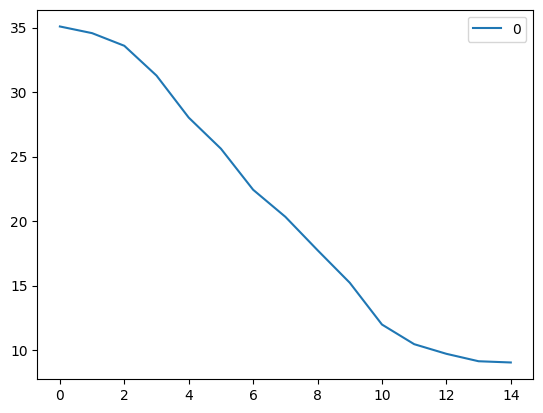

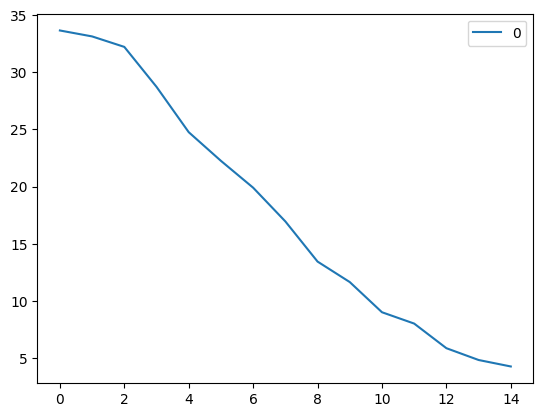

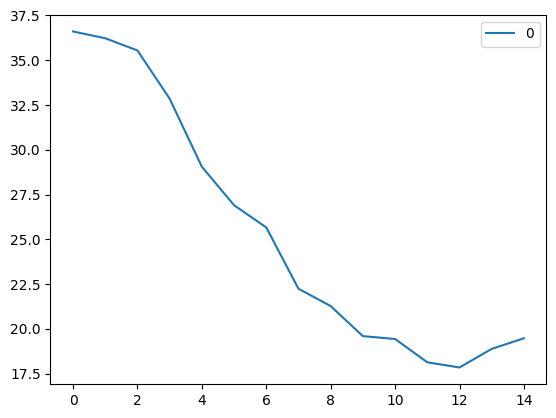

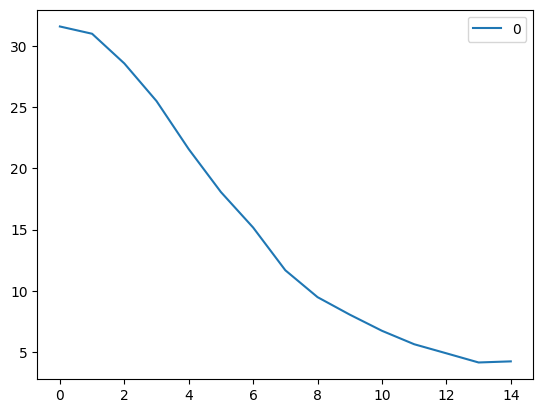

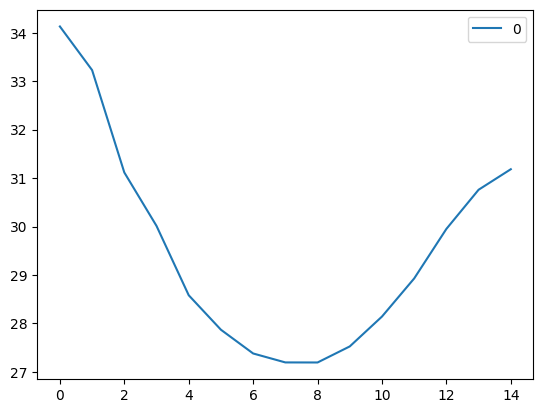

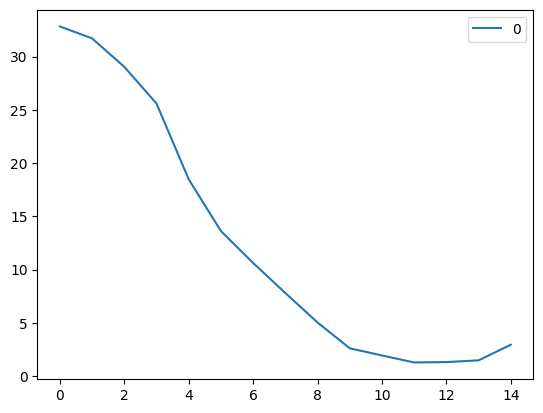

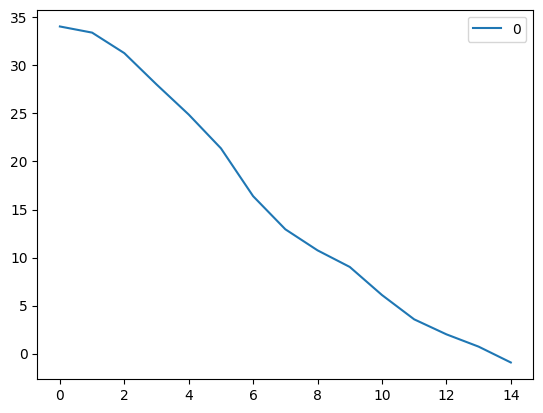

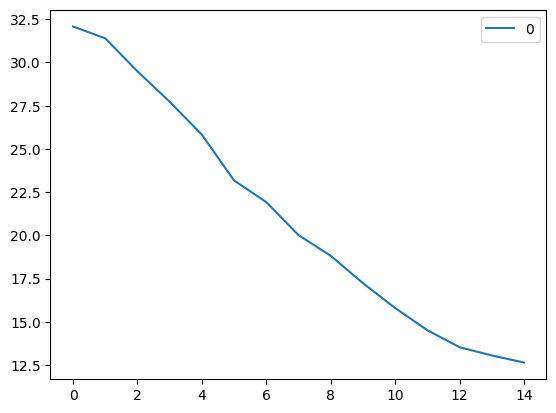

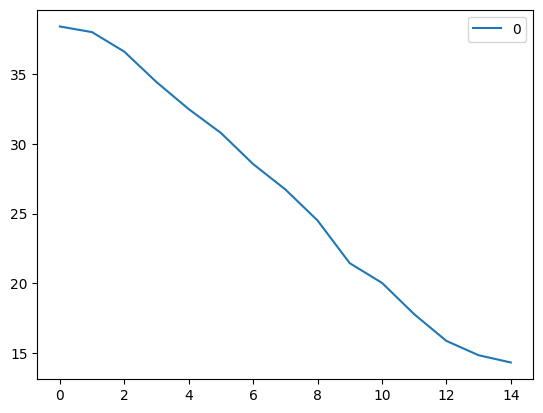

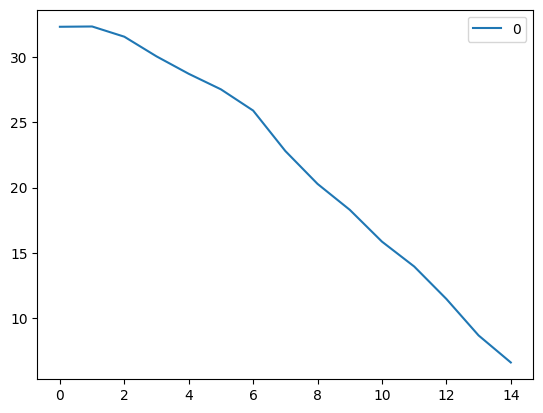

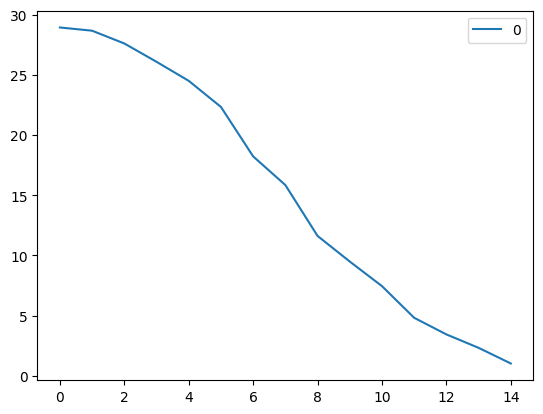

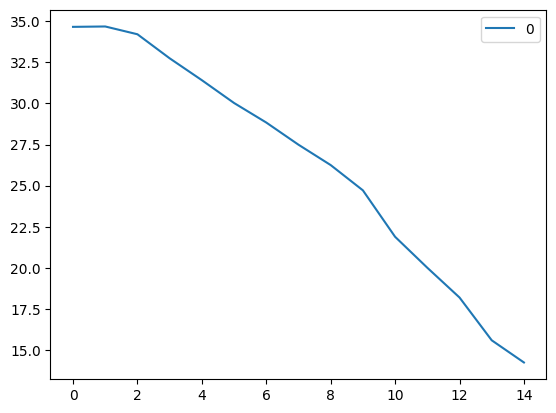

In [70]:
#MOSTRA AS PREVISÕES
for prev in previsoes:
    prev.plot()

In [65]:
ativo_df_prev = preparar_dados_financeiros("KLBN11.SA",1,start="2022-01-01",end="2023-07-25",remove_out=False)

tsi_df_prev= GetTsi(ativo_df_prev, 80, 0.009)


fig = go.Figure()

fig.add_trace(go.Scatter(x=tsi_df_prev.index, y=tsi_df_prev["tsi"]))
fig.add_trace(go.Scatter(x=tsi_df_prev.index, y=tsi_df_prev["gaussian"]))

fig.show()

KLBN11.SA
[*********************100%***********************]  1 of 1 completed


In [66]:
fig = go.Figure(data=[go.Candlestick(x=ativo_df_prev.index,
                open=ativo_df_prev['Open'],
                high=ativo_df_prev['High'],
                low=ativo_df_prev['Low'],
                close=ativo_df_prev['Close'])])

fig.show()